# **Fire Detection**

---
---

Dataset yang digunakan pada pemodelan ini adalah gambar-gambar kebakaran dan tidak kebakaran. Pemodelan ini adalah prototype awal dalam pembuatan CCTV yang bisa mendeteksi adanya kebakaran di suatu lokasi. Gambar-gambar ini dimisalkan adalah frame per detik ketika kebakaran terjadi. Bila prototype ini berhasil harapan akhirnya adalah penghematan biaya bila dibandingkan dengan sensor kebakaran.

URL Dataset : https://www.kaggle.com/datasets/phylake1337/fire-dataset/download<br>
web         : https://fire-detection-prototype.herokuapp.com/

---

## **Import Pustaka**

---

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten, BatchNormalization
from PIL import Image

from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

Import pustaka yang akan digunakan pada analisa dataset ini

----

## **Data Loading**

---

In [1]:
!mkdir -p ~/.kaggle #bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle

In [3]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle

kaggle.json


In [4]:
!kaggle datasets download -d phylake1337/fire-dataset

 95% 369M/387M [00:03<00:00, 148MB/s]
100% 387M/387M [00:03<00:00, 129MB/s]


In [6]:
!unzip -q /content/fire-dataset.zip -d images

In [7]:
main_path= '/content/images/fire_dataset'
main_dir= os.path.join(main_path, 'fire_dataset')
# test_dir = os.path.join(main_path, 'test')

Menentukan direktori gambar-gambar yang akan digunakan.

In [8]:
fire    = len(os.listdir(os.path.join(main_path, 'fire_images')))
nonfire = len(os.listdir(os.path.join(main_path, 'non_fire_images')))

Membuat variabel fire dan non fire, pada dataset ini sudah terpisahkan untuk folder fire dan non-fire

In [9]:
main_fire= glob.glob(main_path + '/fire_images/*.png')
main_nonfire= glob.glob(main_path + '/non_fire_images/*.png')

Proses mengambil gambar berdasarkan kategori atau foldernya menjadi suatu variabel.

In [16]:
def create_dataframe(list_of_images):
  data=[]
  for image in list_of_images:
    data.append((image, image.split('/')[-2]))

  return pd.DataFrame(data, columns= ['images', 'label'])

main_df= create_dataframe(main_fire + main_nonfire)
main_df= main_df.sample(frac=1, random_state=1).reset_index(drop=True)

Direktori semua file yang akan digunakan disimpan ke dalam dataframe bersama dengan labelnya.

In [17]:
print(main_df.shape)
main_df

(999, 2)


images            label
0    /content/images/fire_dataset/fire_images/fire....      fire_images
1    /content/images/fire_dataset/fire_images/fire....      fire_images
2    /content/images/fire_dataset/fire_images/fire....      fire_images
3    /content/images/fire_dataset/fire_images/fire....      fire_images
4    /content/images/fire_dataset/fire_images/fire....      fire_images
..                                                 ...              ...
994  /content/images/fire_dataset/non_fire_images/n...  non_fire_images
995  /content/images/fire_dataset/fire_images/fire....      fire_images
996  /content/images/fire_dataset/non_fire_images/n...  non_fire_images
997  /content/images/fire_dataset/fire_images/fire....      fire_images
998  /content/images/fire_dataset/fire_images/fire....      fire_images

[999 rows x 2 columns]

Ini adalah dataframe lokasi gambar yang akan digunakan beserta labelnya.

----

## **EDA**

---

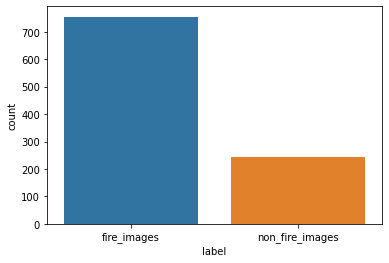

In [18]:
sns.countplot(x='label', data=main_df)

Berdasarkan grafik diatas bisa kita lihat data fire berjumlah lebih banyak dibandingkan dengan non fire.

In [19]:
fire_samples= (main_df[main_df['label']=='fire_images']['images'].iloc[:10]).tolist()
nonfire_samples= (main_df[main_df['label']=='non_fire_images']['images'].iloc[:10]).tolist()

Memisahkan data fire dan nonfire ke dalam list untuk kebutuhan visualisasi pada cell selanjutnya.

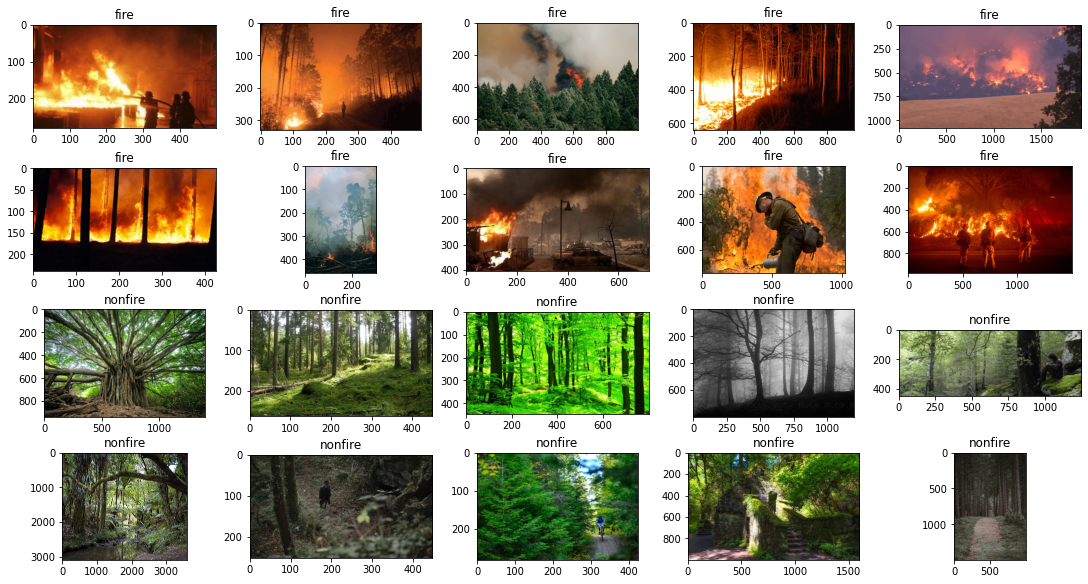

In [20]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 8))
firenum = 0
for i, ax in enumerate(axes.flat):
    if firenum < len(fire_samples):
        img = cv2.imread(fire_samples[firenum])
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        ax.imshow(img)
        ax.set_title('fire')
        firenum += 1
    else:
        img = cv2.imread(nonfire_samples[firenum - len(fire_samples)])
        img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)
        ax.imshow(img)
        ax.set_title('nonfire')
        firenum += 1
plt.tight_layout(pad=0.3)
plt.show()


Berdasarkan visualisasi sample gambar diatas, terlihat ukuran gambar yang akan diolah sangat beragam. Dominasi warna pada gambar fire didominasi oleh warna merah api dan juga orange, pada gambar non-fire karena lokasinya kebanyakan dihutan, warna yang mendominasi adalah hijau.

In [21]:
firepict = main_df[main_df['label']=='fire_images']
nonfirepict = main_df[main_df['label']=='non_fire_images']

Memisahkan label fire dan non fire ke dalam dua dataframe berbeda untuk kebutuhan visualisasi pada cell selanjutnya.

In [22]:
# filenames = ['/home/you/Desktop/chstamp.jpg', '/home/you/Desktop/something.jpg']
sizes = [Image.open(f, 'r').size for f in firepict['images']]
sizes2 = [Image.open(f, 'r').size for f in nonfirepict['images']]
print("Ukuran terbesar pada gambar fire =",max(sizes))
print("Ukuran terbesar pada gambar fire =",min(sizes))
print('-------------------------------------------------------')
print("Ukuran terbesar pada gambar nonfire =",max(sizes2))
print("Ukuran terbesar pada gambar nonfire =",min(sizes2))

Ukuran terbesar pada gambar fire = (6720, 4480)
Ukuran terbesar pada gambar fire = (185, 247)
-------------------------------------------------------
Ukuran terbesar pada gambar nonfire = (5760, 3840)
Ukuran terbesar pada gambar nonfire = (220, 165)


Berikut adalah ukuran terbesar dan terkecil pada gambar fire dan non-fire. Perbedaannya sangat jauh dari ukuran terbesar sampai terkecil.

----

## **Data Preprocessing**

----

### Splitting Dataset

In [23]:
from sklearn.model_selection import train_test_split
train_df, test_df= train_test_split(main_df, test_size=0.1, random_state=22)
train_df, val_df= train_test_split(train_df, test_size=0.1, random_state=22)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)

(100, 2)
(809, 2)
(90, 2)


Splitting menjadi train-test set dan juga validation set.

In [24]:
img_height= 300
img_width= 300
SEED= 1
BATCH= 32

Menentukan parameter untuk mengatur ukuran image agar nanti sama semua, karena seperti yang kita ketahui sebelumnya kalau data gambar yang akan dilatih mempunyai ukuran yang bervariasi.

In [25]:
# Augmentasi data
train_datagen= ImageDataGenerator(
    rescale= 1./255,
    width_shift_range= 0.2,
    height_shift_range= 0.2,
    zca_whitening= True,
    zca_epsilon= 1e-05,
    fill_mode= 'nearest'
)

val_datagen= ImageDataGenerator(rescale= 1./255)
test_datagen= ImageDataGenerator(rescale= 1./255)


Pipeline augmentasi data untuk melakukan manipulasi pada gambar dengan menggunakan rescale, width_shift_range, height_shift range, zca_whitening, zca_epsilon, dan nearest. Pemilihan parameter ini menyesuaikan dengan gambar yang akan dipakai. Karena ini nantinya akan digunakan di cctv yang mana penempatan posisinya statik, maka tidak digunakan parameter seperti horizontal atau vertikal flip. Augmentasi ini banyak diberikan parameter hanya pada data train saja.

In [26]:
ds_train= train_datagen.flow_from_dataframe(
    dataframe= train_df,
    x_col= 'images',
    y_col= 'label',
    target_size= (img_height,img_width),
    color_mode= 'rgb',
    class_mode= 'binary',
    batch_size= BATCH,
    shuffle= True,
    seed= SEED
)

ds_val= val_datagen.flow_from_dataframe(
    dataframe= val_df,
    x_col= 'images',
    y_col= 'label',
    target_size= (img_height,img_width),
    color_mode= 'rgb',
    class_mode= 'binary',
    batch_size= BATCH,
    shuffle= False,
    seed= SEED
)

ds_test= test_datagen.flow_from_dataframe(
    dataframe= test_df,
    x_col= 'images',
    y_col= 'label',
    target_size= (img_height,img_width),
    color_mode= 'rgb',
    class_mode= 'binary',
    batch_size= BATCH,
    shuffle= False,
    seed= SEED
)

Found 809 validated image filenames belonging to 2 classes.
Found 90 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


Proses flow from dataframe karena data gambar-gambar sudah kita konversi ke dalam dataframe. Target size sudah ditentukan sebelumnya (300x300). Karena data gambar hanya memiliki 2 kelas maka menggunakan class mode = binary. Setelah itu ditransformasi.

In [27]:
ds_train.class_indices

{'fire_images': 0, 'non_fire_images': 1}

Untuk label telah diubah menjadi binary dengan fire images menjadi 0 dan non_images menjadi 1.

----

## **Model Definition**

----

In [28]:
callbacks= [
            EarlyStopping(monitor= 'val_loss', mode='min', patience= 5, verbose=1),
            ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only= True)
            #ReduceLROnPlateau
]

Membuat callbacks early stopping agar tidak membuang performa pc ketika training data tidak membaik. ModelCheckpoint untuk menyimpan model ketika memberikan val_loss terbaik.

In [29]:
input= [img_height,img_width,3]
#Conv ke 1
base_model= Sequential()
base_model.add(Conv2D(filters=16, kernel_size=3, input_shape= input))
base_model.add(MaxPooling2D())

#Conv ke 2
base_model.add(Conv2D(filters=32, kernel_size=3, input_shape= input))
base_model.add(MaxPooling2D())

base_model.add(Flatten())

#Fully connected 1st layer
base_model.add(Dense(units=64))
base_model.add(BatchNormalization())

base_model.add(Dense(units=1, activation= 'sigmoid'))

base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 170528)            0         
                                                                 
 dense (Dense)               (None, 64)                1

Berikut adalah arsitektur sequential pada base model :

- 2 kali konvolusi 2 dimensi dengan filter berjumlah 16 dan 32. kernel size berukuran 3x3.<br>
- 2 kali MaxPooling dengan ukuran 2x2 dan jarak pooling adalah 2 piksel.

- Selanjutnya proses flatten pada hasil akhir konvolusi

- Terdapat 1 layer pada neural network dengan 64 neuron.<br>
- Terdapat output yang berjumlah 1 neuron dengan activation sigmoid.

In [30]:
base_model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics= ['accuracy'])

Base model dicompile dengan parameter sebagai berikut:

Optimizer adam
loss binary crossentropy (karena label hanya ada 2 class)
metrics accuracy

----

## **Model Training**

----

In [31]:
epochs= 10
history= base_model.fit(ds_train, batch_size= BATCH, epochs= epochs,
                         validation_data= ds_val, callbacks= callbacks, verbose=1)

Epoch 1/10
26/26 [==============================] - 95s 4s/step - loss: 1.1015 - accuracy: 0.7281 - val_loss: 0.1606 - val_accuracy: 0.9667
Epoch 2/10
26/26 [==============================] - 103s 4s/step - loss: 0.4975 - accuracy: 0.8072 - val_loss: 0.1592 - val_accuracy: 0.9667
Epoch 3/10
26/26 [==============================] - 89s 3s/step - loss: 0.3287 - accuracy: 0.8504 - val_loss: 0.6069 - val_accuracy: 0.7778
Epoch 4/10
26/26 [==============================] - 88s 3s/step - loss: 0.2947 - accuracy: 0.8826 - val_loss: 0.1410 - val_accuracy: 0.9556
Epoch 5/10
26/26 [==============================] - 87s 3s/step - loss: 0.2747 - accuracy: 0.8962 - val_loss: 0.1141 - val_accuracy: 0.9778
Epoch 6/10
26/26 [==============================] - 90s 3s/step - loss: 0.2417 - accuracy: 0.9036 - val_loss: 0.1539 - val_accuracy: 0.9667
Epoch 7/10
26/26 [==============================] - 88s 3s/step - loss: 0.2273 - accuracy: 0.9110 - val_loss: 0.0950 - val_accuracy: 0.9667
Epoch 8/10
26/26 [=

Proses train model dengan 10 epoch, 32 batch, callback (early stopping dan model checkpoint), dari data pipeline yang telah dibuat sebelumnya.

----

## **Model Evaluation**

----

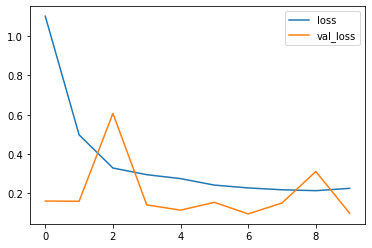

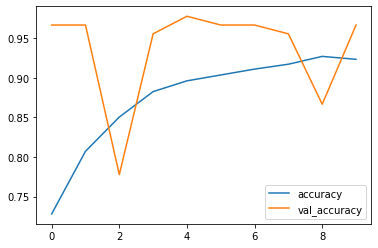

In [32]:
metrics = pd.DataFrame(history.history)
metrics.head()
metrics[['loss','val_loss']].plot();
metrics[['accuracy','val_accuracy']].plot();

Berdasarkan grafik loss dan akurasi di atas didapatkan beberapa poin sebagai berikut:

Proses training selesai di epoch 10 yang berarti tidak ada pengaruh earlystopping.

Training loss sudah terlihat stagnan dari epoch 4 dengan score cukup baik. Score dari validation loss berdekatan dengan socre training loss mengindikasi model ini cukup good fit.
Di epoch ke 8 accuracy bernilai maksimum dan cenderung turun di epoch berikutnya.
Epoch 6 memberikan nilai val_loss minimum maka model di epoch 6 akan disimpan.

In [33]:
y_pred_seq = base_model.predict(ds_test)
y_pred_seq = np.where(y_pred_seq > 0.5, 1, 0).squeeze()

y_pred_seq = np.where(y_pred_seq>0,'non_fire_images','fire_images')
print(classification_report(test_df['label'], y_pred_seq))

                 precision    recall  f1-score   support

    fire_images       0.94      1.00      0.97        74
non_fire_images       1.00      0.81      0.89        26

       accuracy                           0.95       100
      macro avg       0.97      0.90      0.93       100
   weighted avg       0.95      0.95      0.95       100



----

## **Model Improvement**

----

In [34]:
input= [img_height,img_width,3]
#Conv ke 1
improve_model= Sequential()
improve_model.add(Conv2D(filters=16, kernel_size=3, activation= 'relu', input_shape= input))
improve_model.add(MaxPooling2D())
improve_model.add(Dropout(0.2))

#Conv ke 2
improve_model.add(Conv2D(filters=32, kernel_size=3, activation= 'relu', input_shape= input))
improve_model.add(MaxPooling2D())
improve_model.add(Dropout(0.2))


improve_model.add(Flatten())

#Fully connected 1st layer
improve_model.add(Dense(units=128, activation= 'relu'))
improve_model.add(Dropout(0.2))

#Fully connected 2nd layer
improve_model.add(Dense(units=64, activation= 'relu'))
improve_model.add(Dropout(0.2))

#Fully connected 3rd layer
improve_model.add(Dense(units=16, activation= 'relu'))
improve_model.add(Dropout(0.2))

#Fully connected 4th layer
improve_model.add(Dense(units=8, activation= 'relu'))
improve_model.add(Dropout(0.2))


improve_model.add(Dense(units=1, activation= 'sigmoid'))

improve_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 149, 149, 16)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 73, 73, 32)       

Berikut adalah arsitektur sequential pada model yang telah diimprove seperti:

- menambahkan dropout (0.2) pada 2 convolutional layer
- menambah 3 input layer (menjadi 4) dengan jumlah neuron masing-masing 128, 64, 16 dan 8. Ada juga tambahan droput pada setiap layernya
- total parameter bertambah dari 10,919,265 menjadi 21,842,241

In [35]:
improve_model.compile(optimizer='Adamax', loss= 'binary_crossentropy', metrics= ['accuracy'])

Model yang telah diimprove selanjutnya dicompile dengan parameter sebagai berikut:

- Optimizer adamax
- loss binary crossentropy (karena label hanya ada 2 class)
- metrics accuracy

----

## **Model Training**

----

In [36]:
%%time
epochs2 = 20
history2= improve_model.fit(ds_train, batch_size= BATCH, epochs= epochs2,
                         validation_data= ds_val, callbacks= callbacks, verbose=1)

Epoch 1/20
26/26 [==============================] - 100s 4s/step - loss: 0.7484 - accuracy: 0.6020 - val_loss: 0.6887 - val_accuracy: 0.7889
Epoch 2/20
26/26 [==============================] - 94s 4s/step - loss: 0.6872 - accuracy: 0.7145 - val_loss: 0.6845 - val_accuracy: 0.7889
Epoch 3/20
26/26 [==============================] - 94s 4s/step - loss: 0.6219 - accuracy: 0.7219 - val_loss: 0.4408 - val_accuracy: 0.7889
Epoch 4/20
26/26 [==============================] - 95s 4s/step - loss: 0.4821 - accuracy: 0.7219 - val_loss: 0.3453 - val_accuracy: 0.8333
Epoch 5/20
26/26 [==============================] - 94s 4s/step - loss: 0.4307 - accuracy: 0.7417 - val_loss: 0.3657 - val_accuracy: 0.9111
Epoch 6/20
26/26 [==============================] - 95s 4s/step - loss: 0.4034 - accuracy: 0.8257 - val_loss: 0.2573 - val_accuracy: 0.9222
Epoch 7/20
26/26 [==============================] - 98s 4s/step - loss: 0.3314 - accuracy: 0.8690 - val_loss: 0.1785 - val_accuracy: 0.9222
Epoch 8/20
26/26 [=

Proses train model dengan 10 epoch, 32 batch, callback (early stopping dan model checkpoint), dari data pipeline yang telah dibuat sebelumnya.

----

## **Model Evaluation**

----

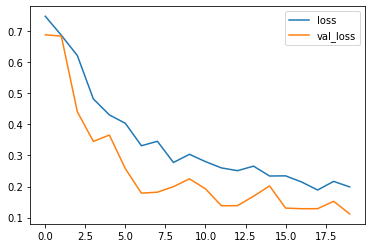

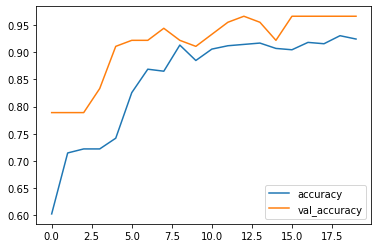

In [37]:
metrics2 = pd.DataFrame(history2.history)
metrics2.head()
metrics2[['loss','val_loss']].plot()
metrics2[['accuracy','val_accuracy']].plot()

Berdasarkan grafik loss dan akurasi di atas didapatkan beberapa poin sebagai berikut:

- Proses training selesai di epoch 20 yang berarti tidak ada pengaruh earlystopping.
- Trend dari Training loss terun menurun sampai dengan epoch 20. Score dari validation loss terlihat tidak terlalu good fit.
- Di epoch ke 19 accuracy bernilai maksimum dan cenderung turun di epoch berikutnya.
- Epoch 20 memberikan nilai val_loss minimum maka model di epoch 20 akan disimpan.

In [38]:
y_pred_seq2 = improve_model.predict(ds_test)
y_pred_seq2 = np.where(y_pred_seq2 > 0.5, 1, 0).squeeze()

y_pred_seq2 = np.where(y_pred_seq2>0,'non_fire_images','fire_images')
print(classification_report(test_df['label'], y_pred_seq2))
print('==================== Bandingkan Dengan Model Sebelumnya ====================')
print(classification_report(test_df['label'], y_pred_seq))

                 precision    recall  f1-score   support

    fire_images       0.99      1.00      0.99        74
non_fire_images       1.00      0.96      0.98        26

       accuracy                           0.99       100
      macro avg       0.99      0.98      0.99       100
   weighted avg       0.99      0.99      0.99       100

==================== Bandingkan Dengan Model Sebelumnya ====================
                 precision    recall  f1-score   support

    fire_images       0.94      1.00      0.97        74
non_fire_images       1.00      0.81      0.89        26

       accuracy                           0.95       100
      macro avg       0.97      0.90      0.93       100
   weighted avg       0.95      0.95      0.95       100



Berdasarkan Classification Report diatas bisa kita lihat kalau Model yang telah diimprove memberikan nilai akurasi yang lebih baik (dari 0.95 jadi 0.99)

----

## **Model Inference**

-----

In [51]:
inference = glob.glob(main_path + '/inference/*.jpg')

Mengambil data gambar inference yang ada di folder 'inference'

In [53]:
inference_df = create_dataframe(inference)
inference_df

images      label
0   /content/images/fire_dataset/inference/11.jpg  inference
1    /content/images/fire_dataset/inference/1.jpg  inference
2   /content/images/fire_dataset/inference/18.jpg  inference
3   /content/images/fire_dataset/inference/12.jpg  inference
4   /content/images/fire_dataset/inference/14.jpg  inference
5    /content/images/fire_dataset/inference/8.jpg  inference
6   /content/images/fire_dataset/inference/13.jpg  inference
7   /content/images/fire_dataset/inference/20.jpg  inference
8    /content/images/fire_dataset/inference/3.jpg  inference
9    /content/images/fire_dataset/inference/7.jpg  inference
10   /content/images/fire_dataset/inference/5.jpg  inference
11  /content/images/fire_dataset/inference/15.jpg  inference
12  /content/images/fire_dataset/inference/19.jpg  inference
13   /content/images/fire_dataset/inference/4.jpg  inference
14   /content/images/fire_dataset/inference/6.jpg  inference
15  /content/images/fire_dataset/inference/10.jpg  inference
16  /content/images/fire_dataset/inference/16.jpg  inference
17   /content/images/fire_dataset/inference/2.jpg  inference
18  /content/images/fire_dataset/inference/17.jpg  inference
19   /content/images/fire_dataset/inference/9.jpg  inference

Konversi data inference ke dalam dataframe dengan direktori tiap file menjadi value dari kolom 'images'

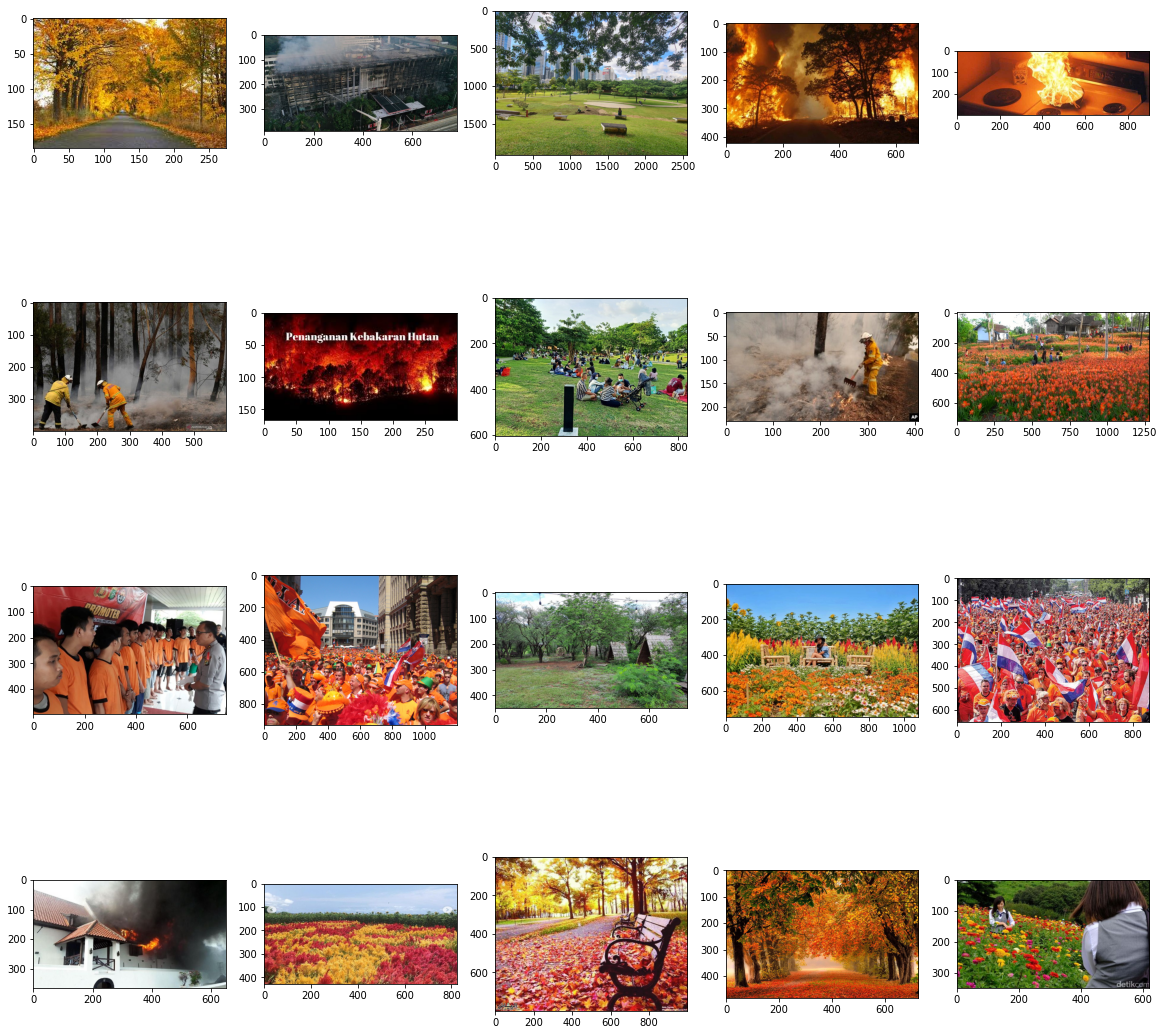

In [54]:
nrows = (len(inference) + 5 - 1)//5
plt.figure(figsize=(20, 5*nrows))
# for i in range(nrows):
for j, path in enumerate(inference_df['images']):
  plt.subplot(nrows, 5, j+1)
  img = cv2.imread(path)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Berikut adalah gambar-gambar yang akan dicoba untuk diprediksi. Inference ini akan sekaligus mengetes model. Pada model training, gambar referensi didominasi warna merah api atau orange. Gambar pada inference ini kebanyakan adalah gambar di suatu lokasi yang nuansa warnanya orange atau merah api. Apakah model bisa mendeteksi dengan benar?

In [55]:
ds_inf = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    dataframe=inference_df,
    x_col = 'images',
    y_col = 'label',
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    class_mode ='categorical',
    batch_size = BATCH,
    shuffle = False,
    seed = SEED)

Found 20 validated image filenames belonging to 1 classes.


Data inference masuk ke dalam pipeline augmentasi data.

In [56]:
best_model = load_model('model_best.hdf5')

Load model terbaik hasil training

In [57]:
y_pred_inf = best_model.predict(ds_inf)
y_pred_inf = np.where(y_pred_inf > 0.5, 1, 0).squeeze()

y_pred_inf = np.where(y_pred_inf>0,'non_fire_images','fire_images')
y_pred_inf

array(['non_fire_images', 'fire_images', 'non_fire_images', 'fire_images',
       'fire_images', 'fire_images', 'fire_images', 'non_fire_images',
       'fire_images', 'fire_images', 'fire_images', 'fire_images',
       'non_fire_images', 'non_fire_images', 'fire_images', 'fire_images',
       'fire_images', 'fire_images', 'non_fire_images', 'non_fire_images'],
      dtype='<U15')

Hasil prediksi dengan menggunakan threshold 0.5

In [58]:
y_pred_inf_df = pd.DataFrame(y_pred_inf, columns=['labelprediction'])
inf_prediction = pd.concat([inference_df, y_pred_inf_df], axis=1)
inf_prediction = inf_prediction.drop('label',1)
inf_prediction

images  labelprediction
0   /content/images/fire_dataset/inference/11.jpg  non_fire_images
1    /content/images/fire_dataset/inference/1.jpg      fire_images
2   /content/images/fire_dataset/inference/18.jpg  non_fire_images
3   /content/images/fire_dataset/inference/12.jpg      fire_images
4   /content/images/fire_dataset/inference/14.jpg      fire_images
5    /content/images/fire_dataset/inference/8.jpg      fire_images
6   /content/images/fire_dataset/inference/13.jpg      fire_images
7   /content/images/fire_dataset/inference/20.jpg  non_fire_images
8    /content/images/fire_dataset/inference/3.jpg      fire_images
9    /content/images/fire_dataset/inference/7.jpg      fire_images
10   /content/images/fire_dataset/inference/5.jpg      fire_images
11  /content/images/fire_dataset/inference/15.jpg      fire_images
12  /content/images/fire_dataset/inference/19.jpg  non_fire_images
13   /content/images/fire_dataset/inference/4.jpg  non_fire_images
14   /content/images/fire_dataset/inference/6.jpg      fire_images
15  /content/images/fire_dataset/inference/10.jpg      fire_images
16  /content/images/fire_dataset/inference/16.jpg      fire_images
17   /content/images/fire_dataset/inference/2.jpg      fire_images
18  /content/images/fire_dataset/inference/17.jpg  non_fire_images
19   /content/images/fire_dataset/inference/9.jpg  non_fire_images

Hasil prediksi dibuat ke dalam dataframe

In [59]:
tesfire = inf_prediction[inf_prediction['labelprediction']=='fire_images']
tesnonfire = inf_prediction[inf_prediction['labelprediction']=='non_fire_images']

Memisahkan gambar dengan hasil prediksi fire dan tidak untuk kebutuhan visualisasi

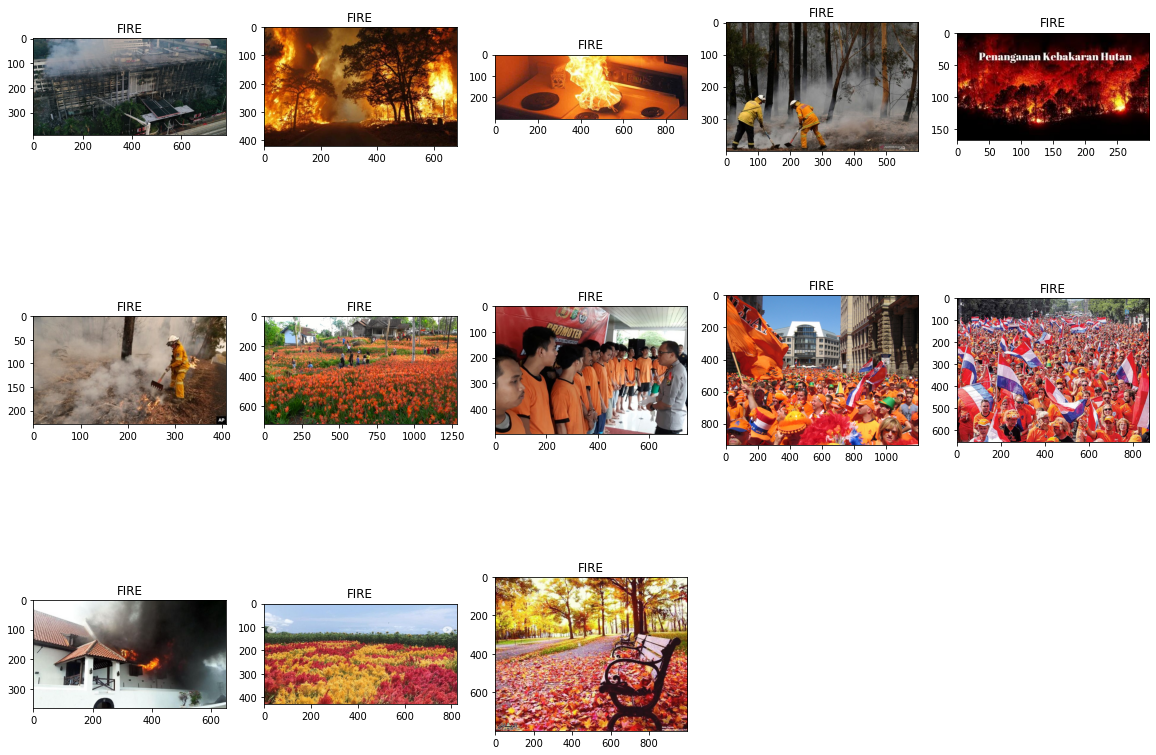

In [60]:
nrows = (len(inference) + 5 - 1)//5
plt.figure(figsize=(20, 5*nrows))
# for i in range(nrows):
for j, path in enumerate(tesfire['images']):
  plt.subplot(nrows, 5, j+1)
  img = cv2.imread(path)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title('FIRE')
  # plt.tight_layout()

Berikut adalah gambar-gambar yang terprediksi fire / ada kebakaran.


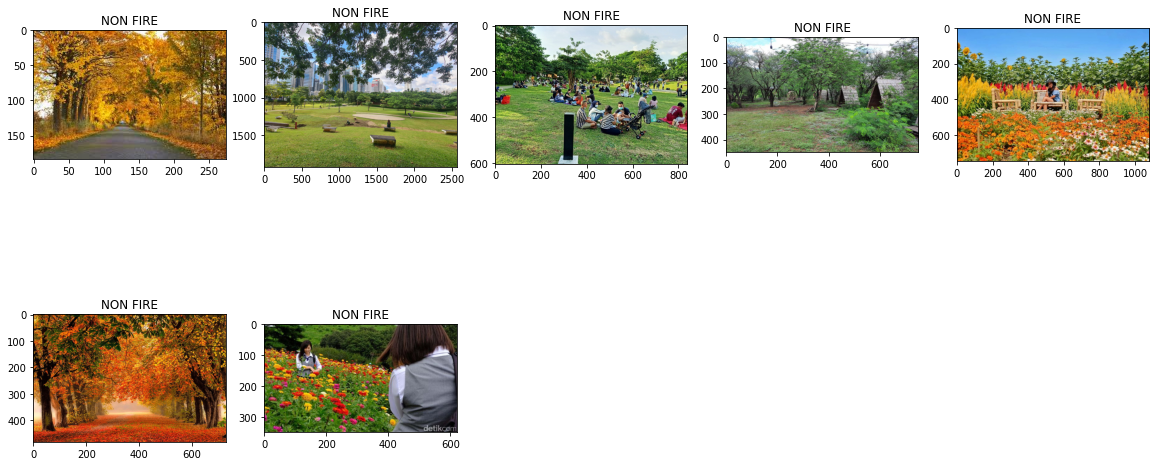

In [61]:
nrows = (len(inference) + 5 - 1)//5
plt.figure(figsize=(20, 5*nrows))
# for i in range(nrows):
for j, path in enumerate(tesnonfire['images']):
  plt.subplot(nrows, 5, j+1)
  img = cv2.imread(path)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.title('NON FIRE')
  # plt.tight_layout()

Berikut adalah gambar-gambar yang terprediksi tidak ada kebakaran.

### *Evaluasi Inference Data*

Gambar yang terprediksi Fire :
1. Semua gambar yang ada api sudah benar terprediksi fire
2. Model masih belum bisa mendetailkan bentuk api karena ketika gambar didominasi warna merah api atau orange, model salah mendeteksi itu sebagai api.
3. Gambar yang hanya ada asap tanpa ada api terprediksi fire (salah prediksi)

Gambar yang terprediksi Non Fire :
1. Tidak ada gambar yang mengandung api baik api besar atau kecil.

----

## **KESIMPULAN**

----

Pemodelan ini yang menggunakan dataset FIRE atau gambar kejadian kebakaran. Kebanyakan gambar berlokasi di hutan atau suatu gedung.

Tahap awal pemodelan membuat base model dengan arsitektur :<br>
- 2 kali konvolusi 2 dimensi dengan filter berjumlah 16 dan 32. kernel size berukuran 3x3.<br>
- 2 kali MaxPooling dengan ukuran 2x2 dan jarak pooling adalah 2 piksel.<br>
- Selanjutnya proses flatten pada hasil akhir konvolusi
- Terdapat 1 layer pada neural network dengan 64 neuron.<br>
- Terdapat output yang berjumlah 1 neuron dengan activation sigmoid.

Selanjutnya ada model improvement dengan arsitektur :
- menambahkan dropout (0.2) pada 2 convolutional layer
- menambah 2 input layer (menjadi 4) dengan jumlah neuron masing-masing 128, 64, 16 dan 8. Ada juga tambahan droput pada setiap layernya
- total parameter bertambah dari 10,919,265 menjadi 21,842,241

Berdasarkan Classification Report diatas bisa kita lihat kalau Model yang telah diimprove memberikan nilai akurasi yang lebih baik (dari 95% jadi 99%) dan juga nilai recall dari 81% menjadi 96%. Pemodelan ini berusaha meminimalisir False Negatif agar jangan sampai ada kebakaran yang tidak terdeteksi karena resikonya sangat besar.

Setelah dilakukan inference pada model didapatkan kesimpulan :
Gambar yang terprediksi Fire :
1. Semua gambar yang ada api sudah benar terprediksi fire
2. Model masih belum bisa mendetailkan bentuk api karena ketika gambar didominasi warna merah api atau orange, model salah mendeteksi itu sebagai api.
3. Gambar yang hanya ada asap tanpa ada api terprediksi fire (salah prediksi)

Gambar yang terprediksi Non Fire :
1. Tidak ada gambar yang mengandung api baik api besar atau kecil.

> Model masih belum bisa membedakan gambar yang dipenuhi benda berwarna merah api atau orange, hal ini dikarenakan tidak ada data dengan kondisi tersebut pada proses training data. Pada pemodelan tahap selanjutnya perlu memasukkan gambar-gambar yang tidak ada kebakaran namun kondisinya banyak objek dengan nuansa warna api. Harapannya model bisa menpelajari dengan baik bentuk dari api.
